In [1]:
import mne
import numpy as np
from pyriemann.classification import MDM
from pyriemann.estimation import Covariances
from scipy.io import loadmat, savemat
from sklearn.pipeline import make_pipeline

from moabb.datasets import download as dl
from moabb.datasets.base import BaseDataset
from moabb.evaluations import CrossSessionEvaluation, WithinSessionEvaluation, CrossSubjectEvaluation
from moabb.paradigms import MotorImagery, FilterBankMotorImagery
import moabb
import warnings
from mne.decoding import CSP
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
moabb.set_log_level("info")
warnings.filterwarnings("ignore")

In [2]:
##############################################################################
# Creating some Data
# ------------------
#
# To illustrate the creation of a dataset class in MOABB, we first create an
# example dataset saved in .mat file. It contains a single fake recording on
# 8 channels lasting for 150 seconds (sampling frequency 256 Hz). We have
# included the script that creates this dataset and have uploaded it online.
# The fake dataset is available on the
# `Zenodo website <https://sandbox.zenodo.org/record/369543>`_


sfreq = 250
num_session = 10
channels = 8
strim = 10 * sfreq
slabs = 5 * sfreq
slen = 60 * sfreq
data_path = "../my_data/" # location of data

def store_subj_data(subj):
    #labels = np.array(([1] * slabs + [2] * slabs) * (slen // (slabs * 2)), dtype=int)
    mdict = {"fs":sfreq}

    for i in range(num_session):
        n = data_path + "s{}_{}.bdf".format(subj, i)
        # only the first 8 are channels, and we remove the buffer
        end = slen + strim
        data = mne.io.read_raw_bdf(n, verbose=10000).get_data()[:channels, strim : end]
        #data_with_labels = np.vstack([data, labels])

        filename = "subject_" + str(subj + 1).zfill(2) + ".mat"
        
        mdict["x" + str(i)] = data
        
    savemat(filename, mdict)

    return data


# Create the fake data
for subject in [0]:
    store_subj_data(subject)

In [3]:
class ExampleDataset(BaseDataset):
    """
    Dataset used to exemplify the creation of a dataset class in MOABB.
    The data samples have been simulated and has no physiological meaning
    whatsoever.
    """

    def __init__(self):
        super().__init__(
            subjects=[1],
            sessions_per_subject=num_session,
            events={"open": 1, "closed": 2},
            code="Example dataset",
            interval=[0, 0.75], # idk what to do for this
            paradigm="imagery", # idk what to do for this 
            doi="",
        )

    def _get_single_subject_data(self, subject):
        """return data for a single subject"""
        file_path_list = self.data_path(subject)

        data = loadmat(file_path_list[0])
        fs = data["fs"]
        sessions = {}

        annot = mne.Annotations(np.arange(0, 60, 5), 5, np.array(["open", "closed"] * 6))
        
        for sess in range(num_session):
            x = data["x" + str(sess)]
            ch_names = ["ch" + str(i) for i in range(8)]
            ch_types = ["eeg" for i in range(8)]
            info = mne.create_info(ch_names, fs, ch_types)
            raw = mne.io.RawArray(x, info)
            raw.set_annotations(annot)
            #raw.plot()
            sessions["session_" + str(sess)] = {}
            sessions["session_" + str(sess)]["run_1"] = raw
        return sessions

    def data_path(
        self, subject, path=None, force_update=False, update_path=None, verbose=None
    ):
        """Download the data from one subject"""
        if subject not in self.subject_list:
            raise (ValueError("Invalid subject number"))

        return ["./subject_01.mat"]


2022-12-09 16:08:12,043 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events
2022-12-09 16:08:12,268 INFO MainThread moabb.evaluations.base Processing dataset: Example dataset
Example dataset-CrossSession: 100%|██████████| 1/1 [00:00<00:00, 566.34it/s]


      score      time  samples subject    session  channels  n_sessions  \
0  0.527778  0.030755    108.0       1  session_0         8          10   
1  0.833333  0.029896    108.0       1  session_1         8          10   
2  0.416667  0.040645    108.0       1  session_2         8          10   
3  0.972222  0.029460    108.0       1  session_3         8          10   
4  0.277778  0.029417    108.0       1  session_4         8          10   
5  0.611111  0.035141    108.0       1  session_5         8          10   
6  0.333333  0.030962    108.0       1  session_6         8          10   
7  0.611111  0.029980    108.0       1  session_7         8          10   
8  0.500000  0.030467    108.0       1  session_8         8          10   
9  0.611111  0.029078    108.0       1  session_9         8          10   

           dataset pipeline  
0  Example dataset      MDM  
1  Example dataset      MDM  
2  Example dataset      MDM  
3  Example dataset      MDM  
4  Example dataset      

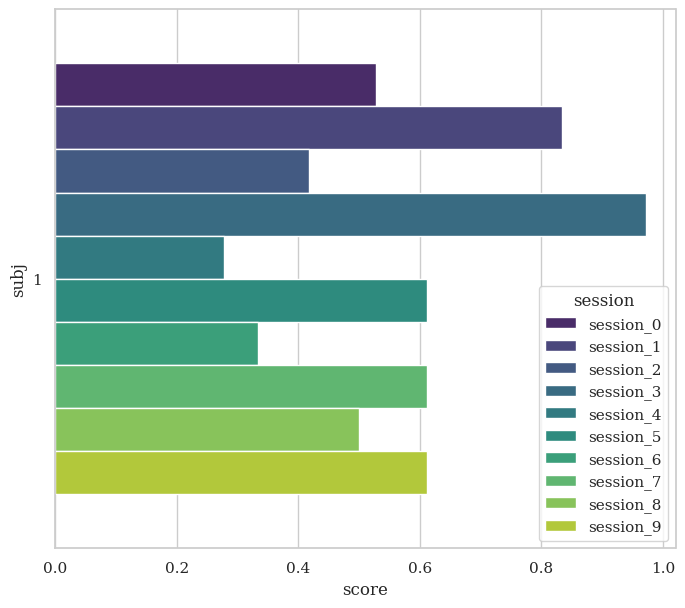

In [6]:
dataset = ExampleDataset()

paradigm = MotorImagery()
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[1])

evaluation = CrossSessionEvaluation(
    paradigm=paradigm, datasets=dataset, overwrite=False, suffix="newdataset"
)
pipelines = {}
pipelines["MDM"] = make_pipeline(Covariances("oas"), MDM(metric="riemann"))
results = evaluation.process(pipelines)

print(results)

fig, ax = plt.subplots(figsize=(8, 7))
results["subj"] = results["subject"].apply(str)
sns.barplot(
    x="score", y="subj", hue="session", data=results, orient="h", palette="viridis", ax=ax
)
plt.show()

In [29]:
dataset = ExampleDataset()
sessions = dataset.get_data(subjects=[1])

pipeline = make_pipeline(CSP(n_components=8), LDA())
evaluation = CrossSessionEvaluation(
    paradigm=paradigm,
    datasets=[dataset],
    overwrite=True,
    hdf5_path=None,
)

In [30]:
results = evaluation.process({"csp+lda": pipeline})

2022-12-09 15:43:41,172 INFO MainThread moabb.evaluations.base Processing dataset: Example dataset
Example dataset-CrossSession:   0%|          | 0/1 [00:00<?, ?it/s]2022-12-09 15:43:41,359 INFO MainThread moabb.evaluations.base csp+lda | Example dataset | 1 | session_0: Score 0.722
2022-12-09 15:43:41,487 INFO MainThread moabb.evaluations.base csp+lda | Example dataset | 1 | session_1: Score 0.361
2022-12-09 15:43:41,556 INFO MainThread moabb.evaluations.base csp+lda | Example dataset | 1 | session_2: Score 0.750
2022-12-09 15:43:41,657 INFO MainThread moabb.evaluations.base csp+lda | Example dataset | 1 | session_3: Score 0.611
2022-12-09 15:43:41,722 INFO MainThread moabb.evaluations.base csp+lda | Example dataset | 1 | session_4: Score 0.750
2022-12-09 15:43:41,784 INFO MainThread moabb.evaluations.base csp+lda | Example dataset | 1 | session_5: Score 0.417
2022-12-09 15:43:41,845 INFO MainThread moabb.evaluations.base csp+lda | Example dataset | 1 | session_6: Score 0.583
2022-12-

In [31]:
results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.722222,0.027606,108.0,1,session_0,8,10,Example dataset,csp+lda
1,0.361111,0.093262,108.0,1,session_1,8,10,Example dataset,csp+lda
2,0.750000,0.055971,108.0,1,session_2,8,10,Example dataset,csp+lda
3,0.611111,0.076535,108.0,1,session_3,8,10,Example dataset,csp+lda
4,0.750000,0.052695,108.0,1,session_4,8,10,Example dataset,csp+lda
5,0.416667,0.048390,108.0,1,session_5,8,10,Example dataset,csp+lda
6,0.583333,0.046791,108.0,1,session_6,8,10,Example dataset,csp+lda
7,0.972222,0.056814,108.0,1,session_7,8,10,Example dataset,csp+lda
8,0.916667,0.059786,108.0,1,session_8,8,10,Example dataset,csp+lda
9,0.722222,0.051692,108.0,1,session_9,8,10,Example dataset,csp+lda


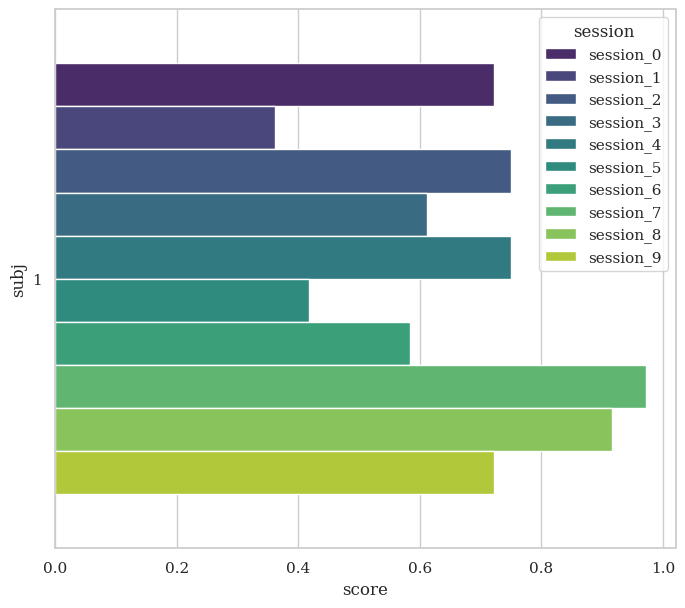

In [32]:
fig, ax = plt.subplots(figsize=(8, 7))
results["subj"] = results["subject"].apply(str)
sns.barplot(
    x="score", y="subj", hue="session", data=results, orient="h", palette="viridis", ax=ax
)
plt.show()